<a href="https://colab.research.google.com/github/rpinedas230/Machine_Learning_Project/blob/main/X_ray_Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciones

In [ ]:
!pip install segmentation-models-3D
!pip install pydicom

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import pydicom
from keras.preprocessing import image
from matplotlib.pyplot import imread
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial import distance
import segmentation_models_3D as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score , auc
from keras.utils.np_utils import to_categorical
import cv2
import gc
from keras.metrics import MeanIoU
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2 , VGG16 , ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.metrics import MeanIoU
from datetime import date
AUTOTUNE = tf.data.AUTOTUNE

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Acceso a los archivos del drive

Mounted at /content/drive


In [ ]:
#Descomprimir la carpeta con los datos
!unzip "/content/drive/MyDrive/Tesis/rsna-pneumonia-detection-challenge.zip"

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflati

# Procesamiento de los datos

In [ ]:
labels  = pd.read_csv("/content/stage_2_train_labels.csv")

In [ ]:
labels.head(10) #Valores Nan se refiere a que la persona no presenta opacidad pulmonar.

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
labels.describe()

x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000

In [ ]:
details = pd.read_csv("/content/stage_2_detailed_class_info.csv")

In [ ]:
details.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [ ]:
# Los duplicados en details tienen la misma clase asi que los podemos sacar
details = details.drop_duplicates('patientId').reset_index(drop=True)
labels_w_class = labels.merge(details, how='inner', on='patientId')

In [ ]:
labels_w_class.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
labels_w_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:

labels_w_class.fillna(0, inplace=True)
labels_w_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
labels_w_class['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
new_df = labels_w_class.head(5000)
new_df.head()


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
df = labels_w_class.copy()


In [ ]:
class_train, class_val = train_test_split(new_df, test_size=0.20, random_state=42, stratify=new_df['class'])
#20% para los datos de prueba

In [ ]:
class_train_full, class_val_full = train_test_split(df, test_size=0.20, random_state=42, stratify=df['class'])

# Creando la mascara

In [ ]:
IMAGE_SIZE = 1024 #Tamaño de la imagen
ADJUSTED_IMAGE_SIZE=128 #Dimensiones de la imagen
MASK_IMAGE_SIZE = 14 #Tamaño de la mascara
FACTOR = MASK_IMAGE_SIZE/IMAGE_SIZE
FACTOR = ADJUSTED_IMAGE_SIZE/IMAGE_SIZE

In [ ]:
X_feature_tr = []
y_feature_target_tr = []
y_feature_coordinates_tr = []
from PIL import Image
train_images_dir = "/content/stage_2_train_images/"
def create_mask(datafm , n_classes = 2 ):
    X = []
    y=[]
    masks = np.zeros((int(datafm.shape[0]), ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE))
    for index, patient_id in enumerate(datafm['patientId'].T.to_dict().values()):
        image_path = train_images_dir+patient_id+".dcm"
        img = pydicom.dcmread(image_path)
        img = img.pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = preprocess_input(np.array(img, dtype=np.float32))
        X.append(img)
        rows = labels_w_class[labels_w_class['patientId']==patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x']*FACTOR)
            x2 = int((row['x']*FACTOR)+(row['width']*FACTOR))
            y1 = int(row['y']*FACTOR)
            y2 = int((row['y']*FACTOR)+(row['height']*FACTOR))
            masks[index][y1:y2, x1:x2] = 1

    del img,row,row_data
    gc.collect()
    X= np.array(X)
    y= np.array(y)

    train_masks_input = np.expand_dims(masks, axis=3)
    train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))

    return X, y, y_train_cat, masks

In [ ]:
X_train, y_tr_target, y_train , mask_train = create_mask(class_train)
X_val, y_val_target, y_val , mask_val  = create_mask(class_val)

In [ ]:
X_train.shape, y_tr_target.shape, y_train.shape, X_val.shape, y_val_target.shape, y_val.shape

((4000, 128, 128, 3),
 (4000,),
 (4000, 128, 128, 2),
 (1000, 128, 128, 3),
 (1000,),
 (1000, 128, 128, 2))

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(buffer_size=AUTOTUNE)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(buffer_size=AUTOTUNE)

# Visualización

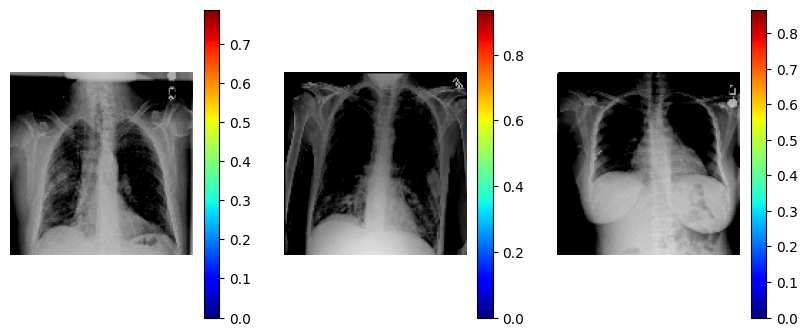

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = X_train[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()
#Se invierten los colores para poder identificar de forma mas sencilla la opacidad pulmonar

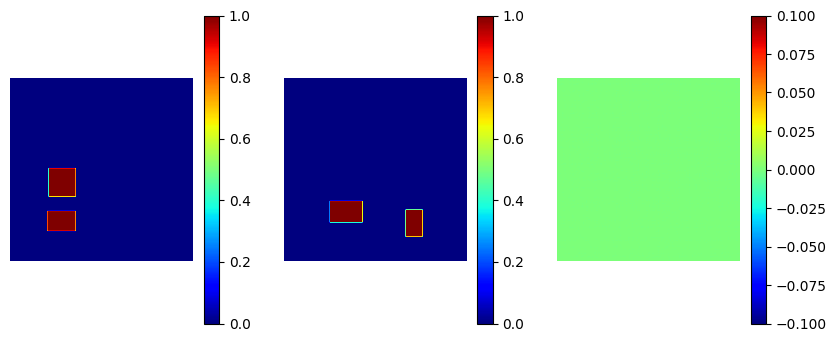

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = mask_train[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

# Creando los modelos


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5,0.5]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = ["accuracy",sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

input_shape = (128,128,3)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape = input_shape , n = 2 ,  lr = 0.0001 , loss = total_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    resnet50.layers[0]._name  = "input_1"

    resnet50._name = "Resnet50"

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics)
    return model



def build_densenet121_unet(input_shape = input_shape, n = 2 , lr = 0.0001 , loss = total_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet =  tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    densenet.layers[0]._name  = "input_1"

    densenet._name = "Densenet121"

    """ Encoder """
    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics)
    return model


def build_mobilenetv2_unet(input_shape = input_shape, n = 2 ,  lr = 0.0001 , loss = total_loss , metrics = metrics):
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs)

    encoder.layers[0]._name  = "input_1"

    encoder._name = "Mobilenetv2"

    """ Encoder """
    s1 = encoder.get_layer("input_1").output
    s2 = encoder.get_layer("block_1_expand_relu").output
    s3 = encoder.get_layer("block_3_expand_relu").output
    s4 = encoder.get_layer("block_6_expand_relu").output

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics)
    return model




model1 = build_resnet50_unet()
model1.summary()

print()
print()
print()
print()


model2 = build_densenet121_unet()
model2.summary()

print()
print()
print()
print()

model3 = build_mobilenetv2_unet()
model3.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNorm





9420800/9406464 [==============================] - 1s 0us/step
Model: "MobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (Re

# Entrenando los modelos

# Entrenando ResNet50 es parte del encoder

In [ ]:
h1 = model1.fit(train, validation_data = val,
      epochs=15)

Epoch 1/15
250/250 [==============================] - 77s 209ms/step - loss: 0.5783 - accuracy: 0.9231 - iou_score: 0.8673 - f1-score: 0.9231 - val_loss: 0.5939 - val_accuracy: 0.9215 - val_iou_score: 0.8553 - val_f1-score: 0.9217
Epoch 2/15
250/250 [==============================] - 50s 199ms/step - loss: 0.5414 - accuracy: 0.9595 - iou_score: 0.9224 - f1-score: 0.9595 - val_loss: 0.5660 - val_accuracy: 0.9281 - val_iou_score: 0.8670 - val_f1-score: 0.9285
Epoch 3/15
250/250 [==============================] - 51s 202ms/step - loss: 0.5310 - accuracy: 0.9696 - iou_score: 0.9412 - f1-score: 0.9696 - val_loss: 0.5457 - val_accuracy: 0.9500 - val_iou_score: 0.9050 - val_f1-score: 0.9500
Epoch 4/15
250/250 [==============================] - 50s 202ms/step - loss: 0.5246 - accuracy: 0.9757 - iou_score: 0.9528 - f1-score: 0.9757 - val_loss: 0.5394 - val_accuracy: 0.9574 - val_iou_score: 0.9191 - val_f1-score: 0.9578
Epoch 5/15
250/250 [==============================] - 51s 203ms/step - loss:

# Entrenando Densenet121 es parte del encoder

In [ ]:
h2 = model2.fit(train, validation_data = val,
      epochs=15)

Epoch 1/15
250/250 [==============================] - 69s 229ms/step - loss: 0.6133 - accuracy: 0.9113 - iou_score: 0.8563 - f1-score: 0.9113 - val_loss: 0.5904 - val_accuracy: 0.9378 - val_iou_score: 0.8835 - val_f1-score: 0.9379
Epoch 2/15
250/250 [==============================] - 53s 213ms/step - loss: 0.5579 - accuracy: 0.9516 - iou_score: 0.9080 - f1-score: 0.9516 - val_loss: 0.5508 - val_accuracy: 0.9525 - val_iou_score: 0.9102 - val_f1-score: 0.9529
Epoch 3/15
250/250 [==============================] - 54s 214ms/step - loss: 0.5432 - accuracy: 0.9612 - iou_score: 0.9255 - f1-score: 0.9612 - val_loss: 0.5488 - val_accuracy: 0.9518 - val_iou_score: 0.9086 - val_f1-score: 0.9520
Epoch 4/15
250/250 [==============================] - 54s 214ms/step - loss: 0.5320 - accuracy: 0.9710 - iou_score: 0.9437 - f1-score: 0.9710 - val_loss: 0.5383 - val_accuracy: 0.9605 - val_iou_score: 0.9247 - val_f1-score: 0.9608
Epoch 5/15
250/250 [==============================] - 53s 212ms/step - loss:

# Entrenando Mobilenetv2 es parte del encoder

In [ ]:
h3 = model3.fit(train, validation_data = val,
      epochs=15)

Epoch 1/15
250/250 [==============================] - 55s 187ms/step - loss: 0.5770 - accuracy: 0.9336 - iou_score: 0.8789 - f1-score: 0.9336 - val_loss: 0.5604 - val_accuracy: 0.9483 - val_iou_score: 0.9024 - val_f1-score: 0.9486
Epoch 2/15
250/250 [==============================] - 44s 176ms/step - loss: 0.5435 - accuracy: 0.9574 - iou_score: 0.9185 - f1-score: 0.9574 - val_loss: 0.5452 - val_accuracy: 0.9516 - val_iou_score: 0.9086 - val_f1-score: 0.9520
Epoch 3/15
250/250 [==============================] - 44s 174ms/step - loss: 0.5331 - accuracy: 0.9666 - iou_score: 0.9356 - f1-score: 0.9666 - val_loss: 0.5603 - val_accuracy: 0.9297 - val_iou_score: 0.8700 - val_f1-score: 0.9303
Epoch 4/15
250/250 [==============================] - 44s 176ms/step - loss: 0.5259 - accuracy: 0.9734 - iou_score: 0.9484 - f1-score: 0.9734 - val_loss: 0.5748 - val_accuracy: 0.9173 - val_iou_score: 0.8488 - val_f1-score: 0.9180
Epoch 5/15
250/250 [==============================] - 43s 173ms/step - loss:

# Evaluación

In [ ]:
def plot(r):

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(r.history['iou_score'], label='iou_score')
    plt.plot(r.history['val_iou_score'], label='val_iou_score')
    plt.title('Iou score Evolution')
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.plot(r.history['f1-score'], label='f1-score')
    plt.plot(r.history['val_f1-score'], label='val_f1-score')
    plt.title('f1-score Evolution')
    plt.legend()

# Metricas de Resnet50

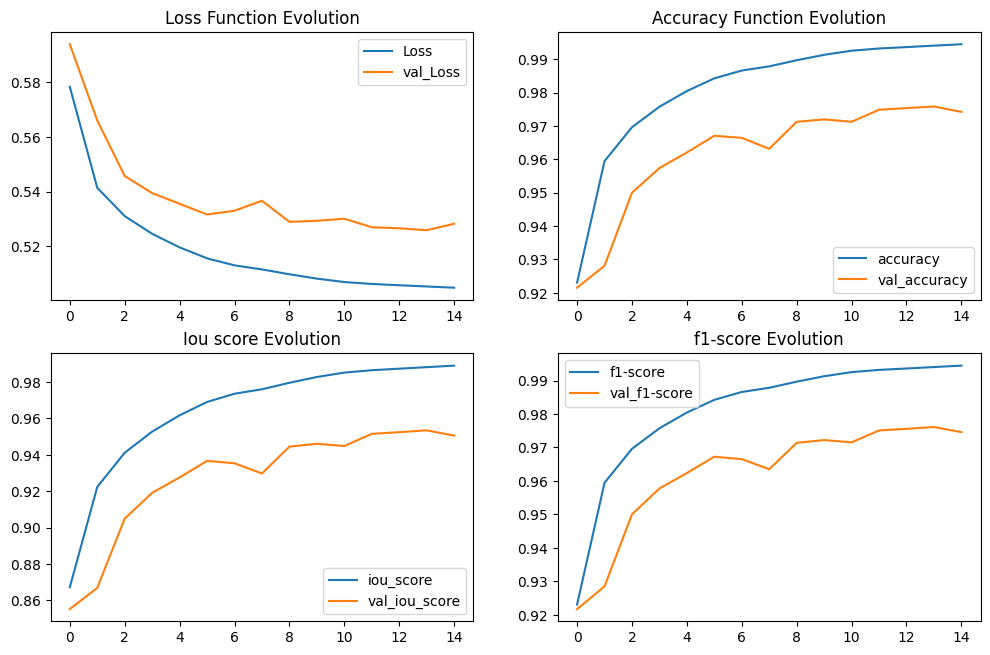

In [ ]:
plot(h1)

# Metricas de densenet121

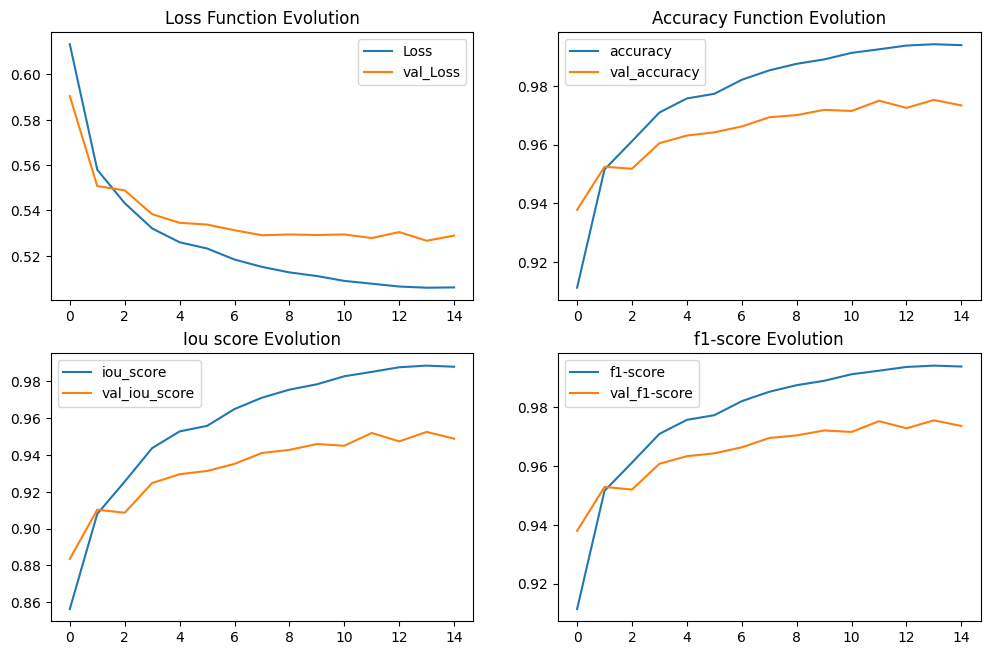

In [ ]:
plot(h2)

# Métricas de Mobilenetv2

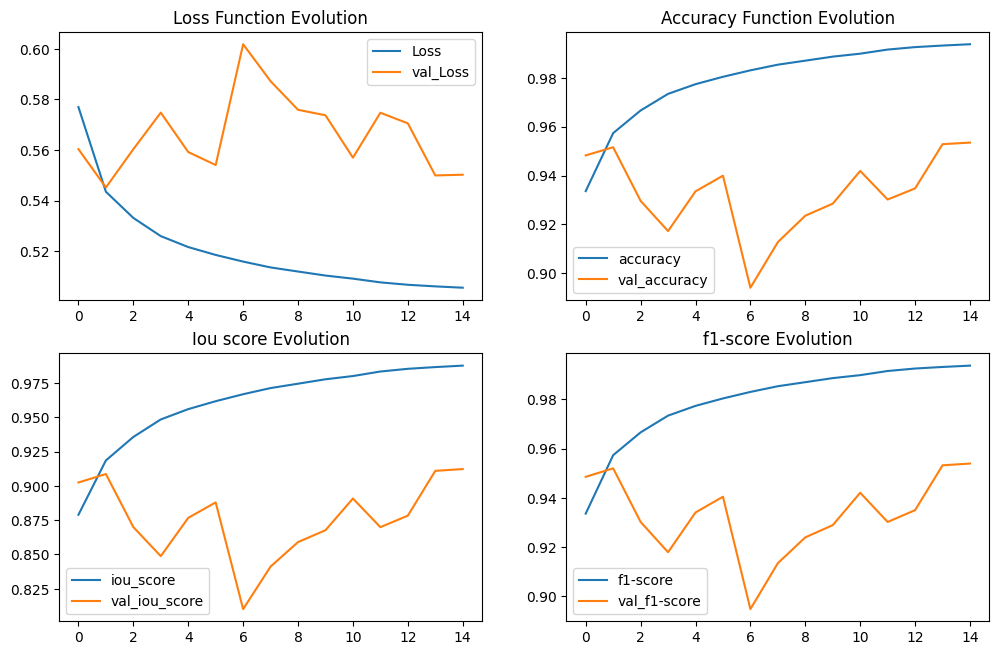

In [ ]:
plot(h3)

In [ ]:

def create_mask1(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(X,y, model ):

    pred_mask = model.predict(X)

    display([X, y, create_mask1(pred_mask)])



def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):

    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if(i == 0):
      plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


# Visualización de Resnet50 Encoder

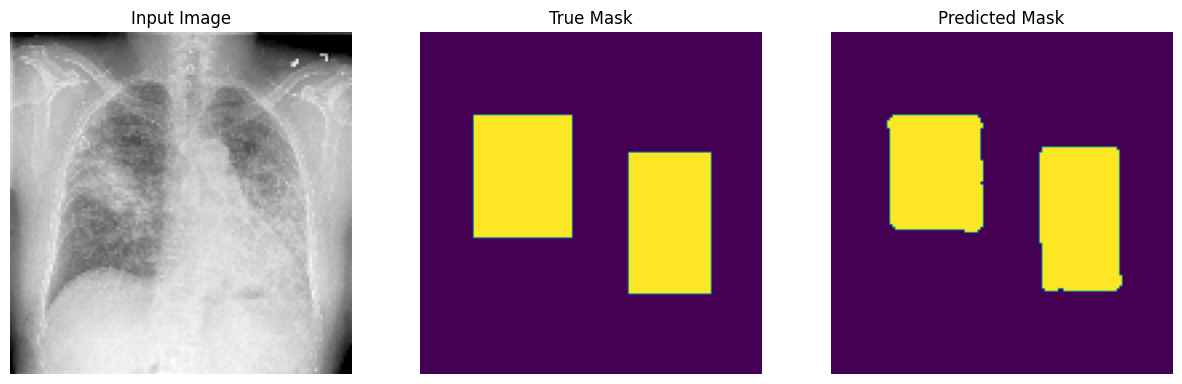

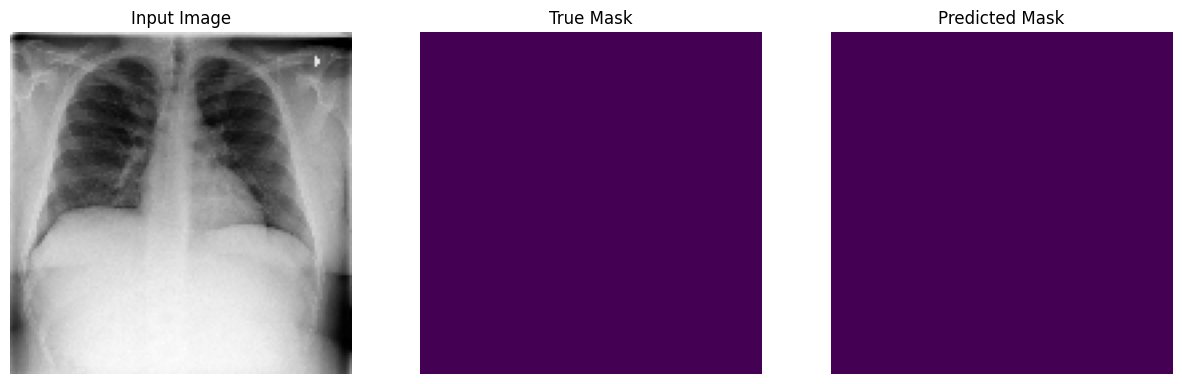

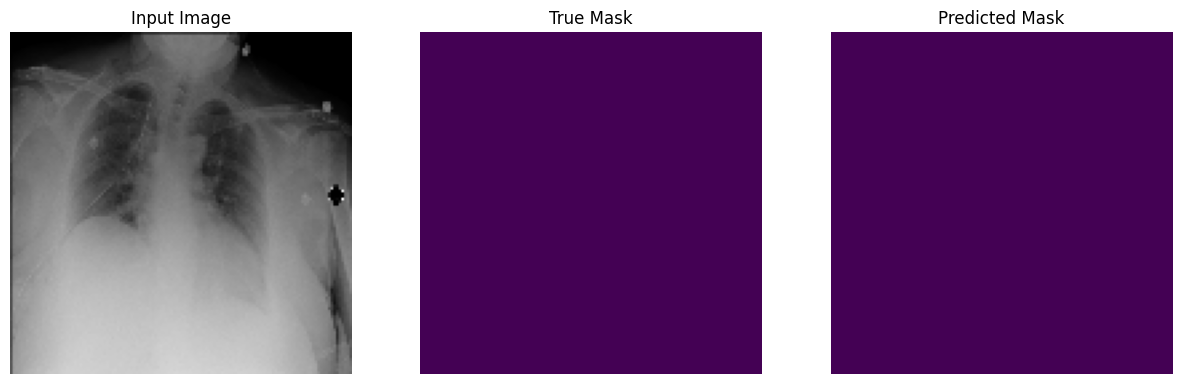

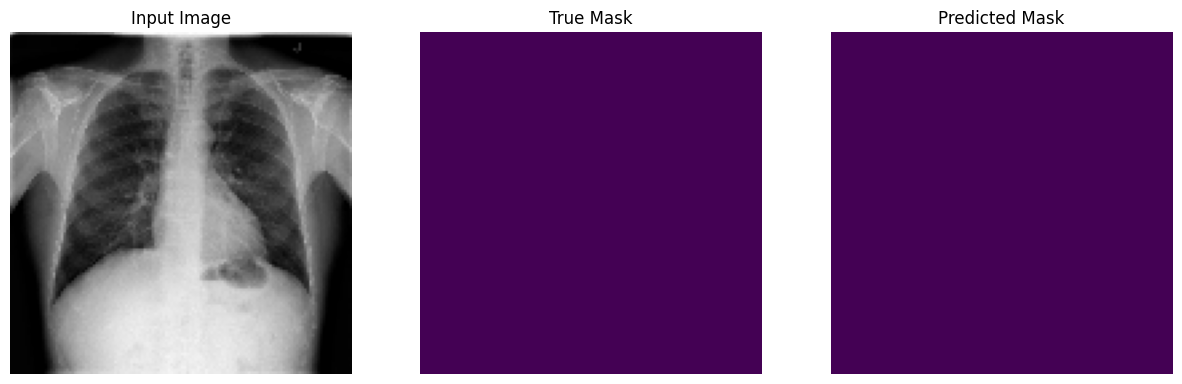

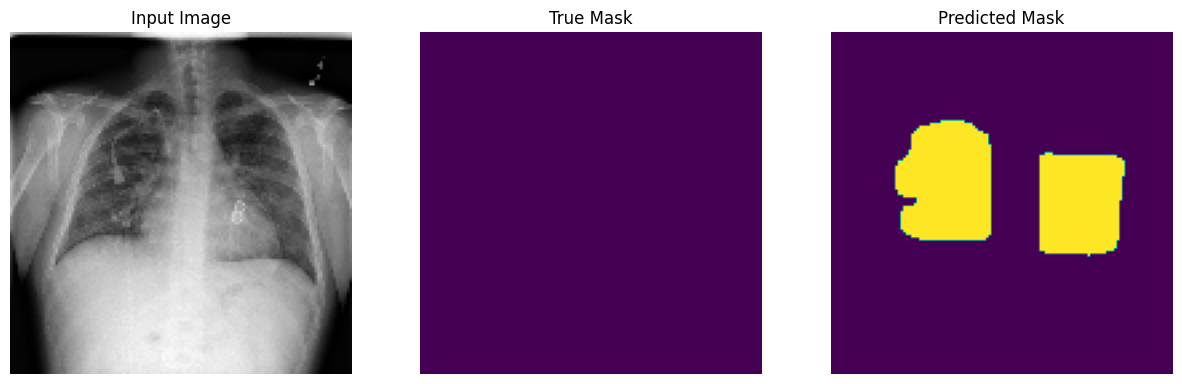

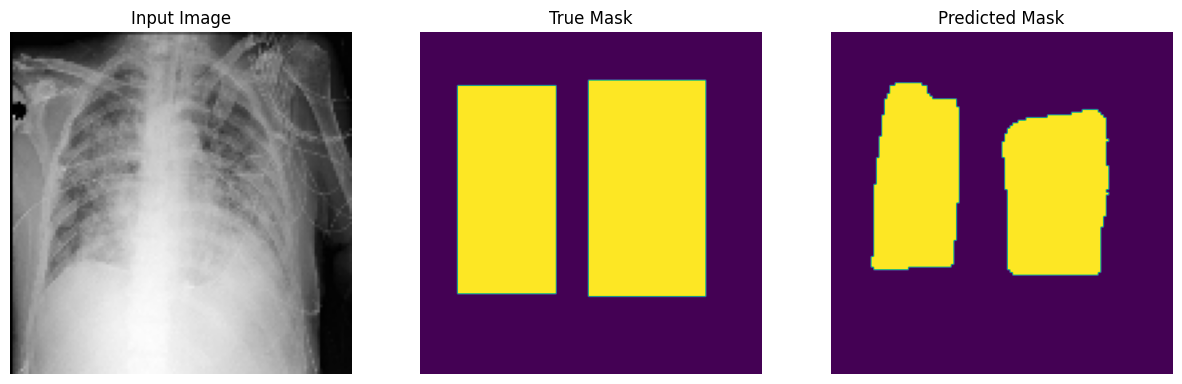

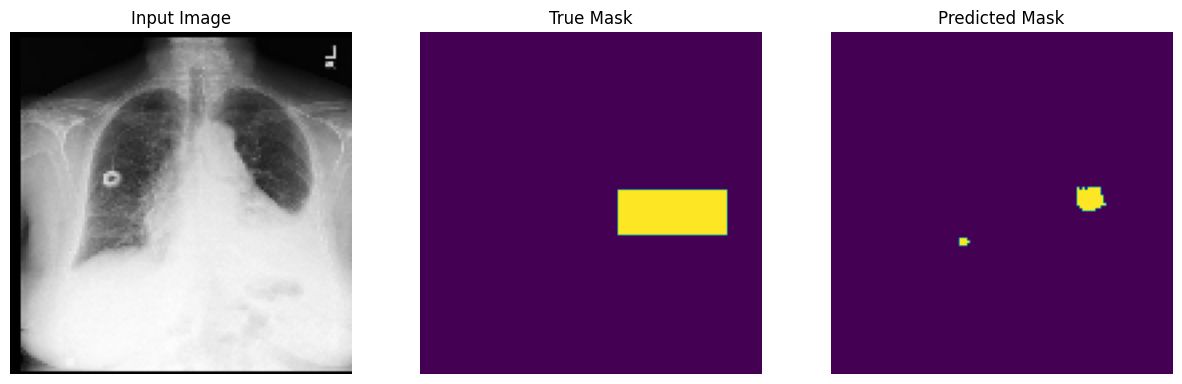

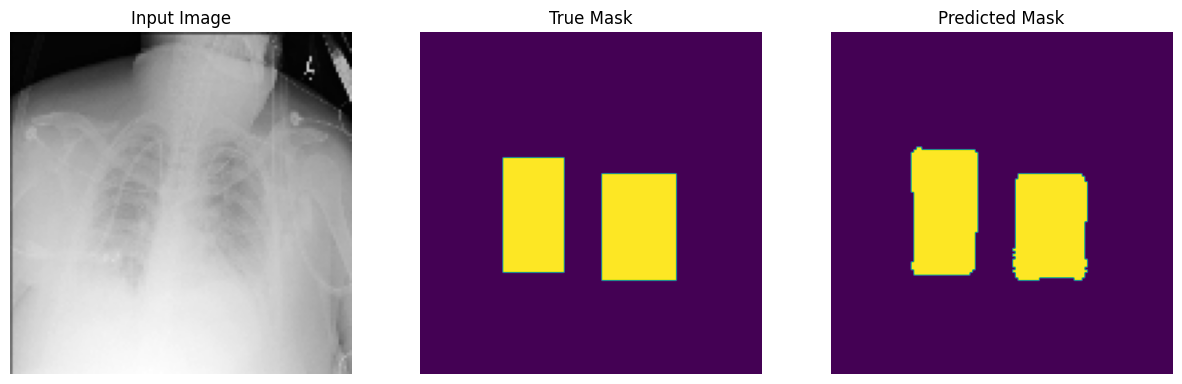

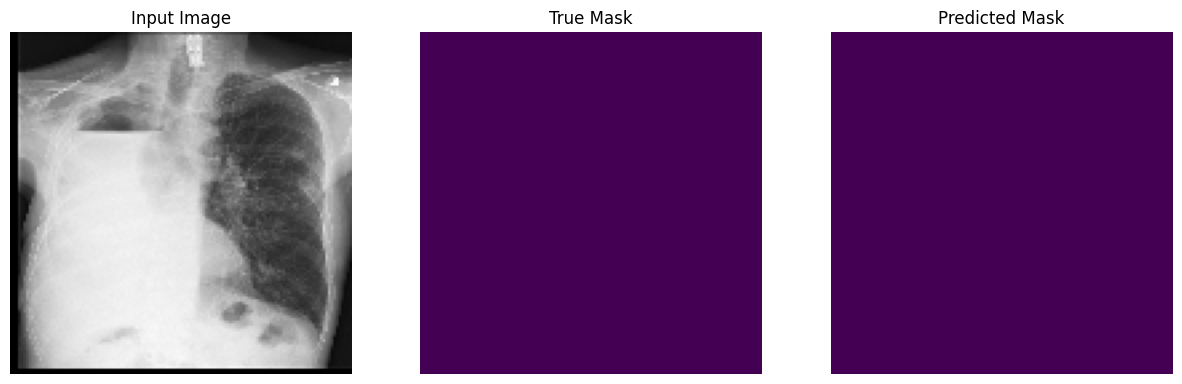

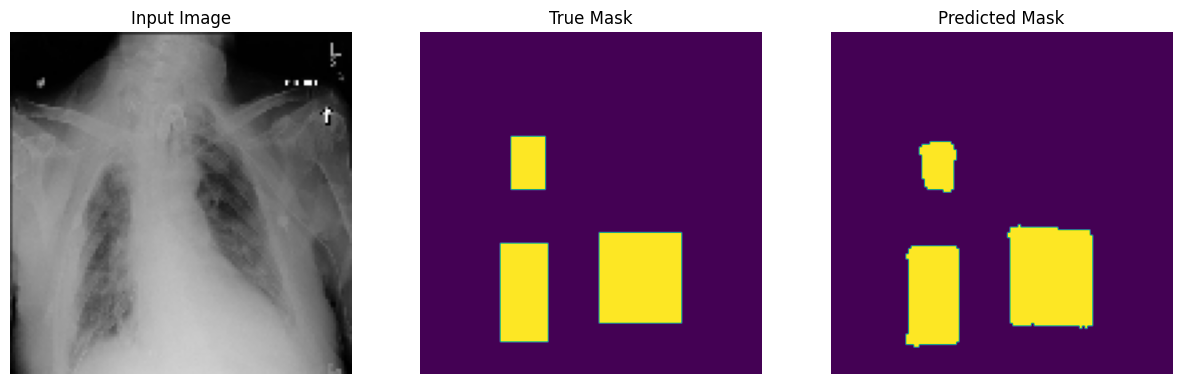

In [ ]:
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model1)

# Visualización de Densenet121 Encoder

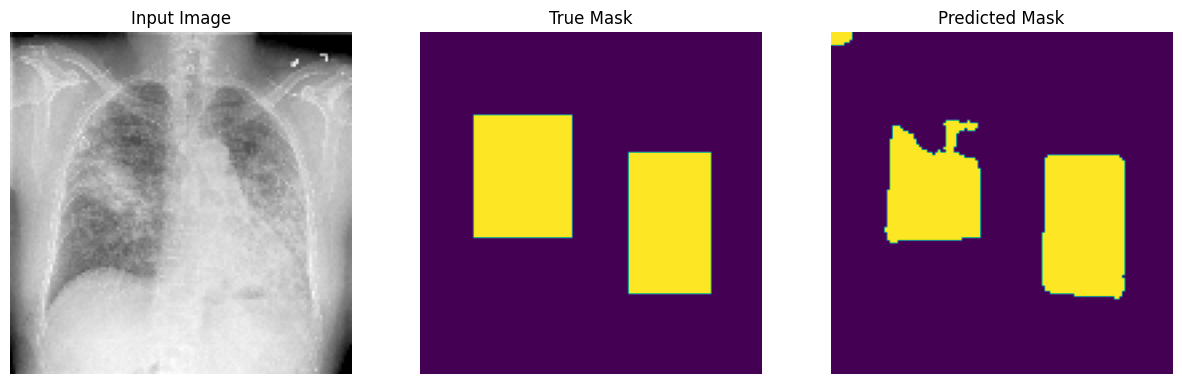

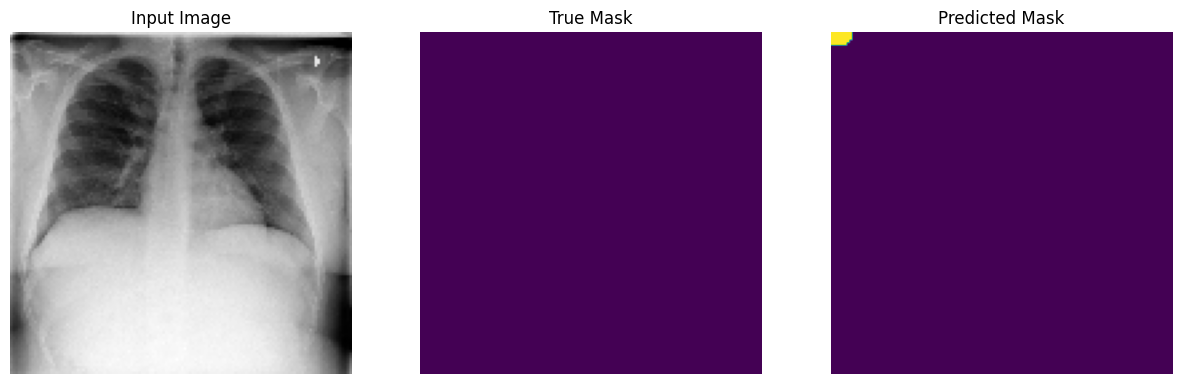

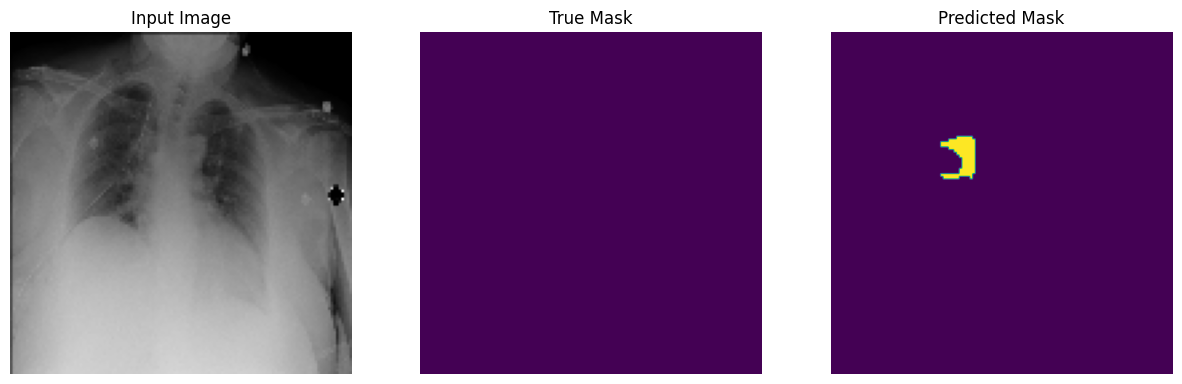

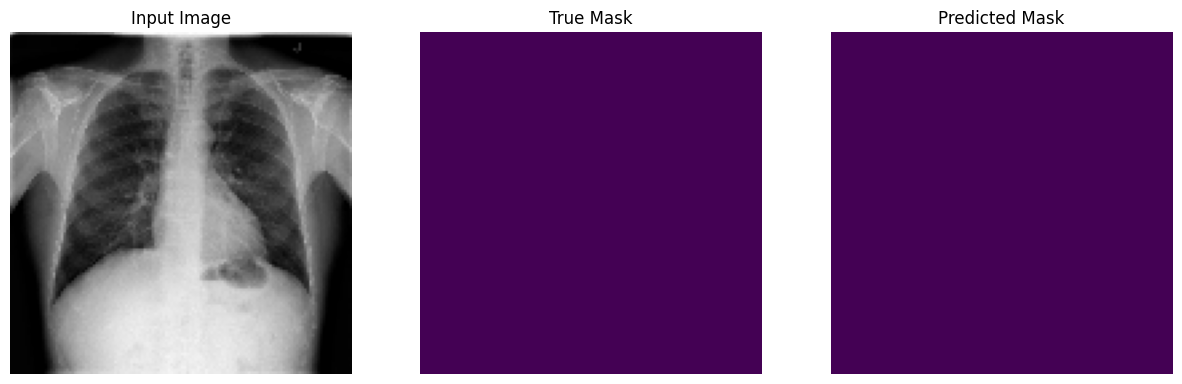

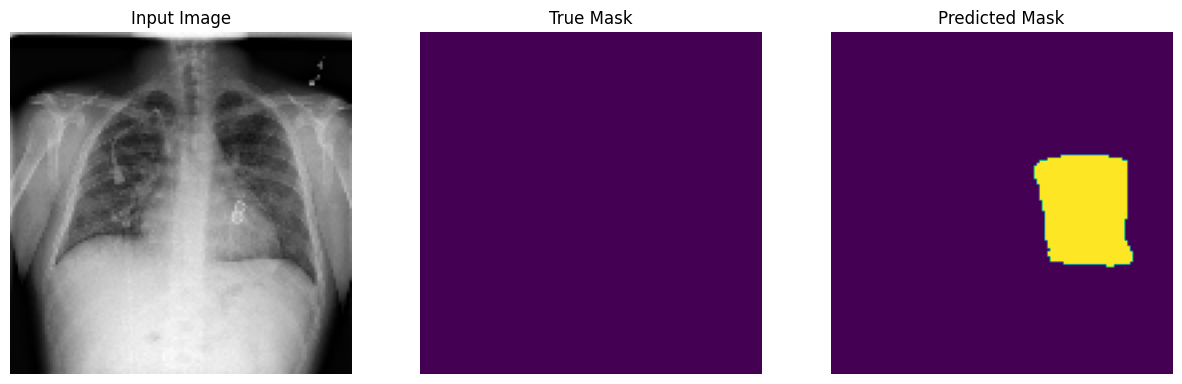

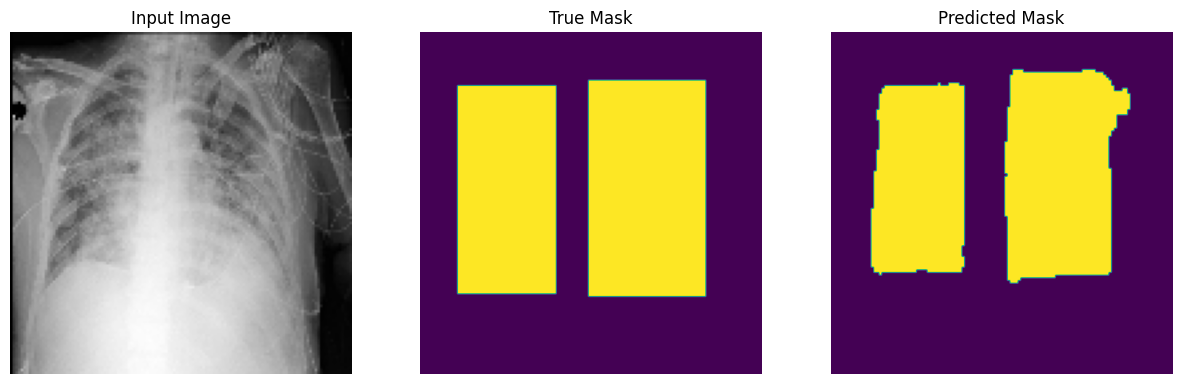

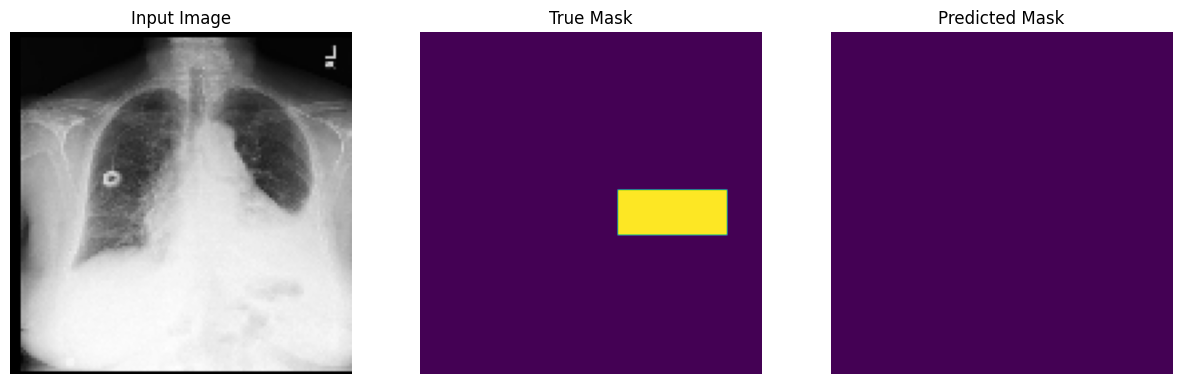

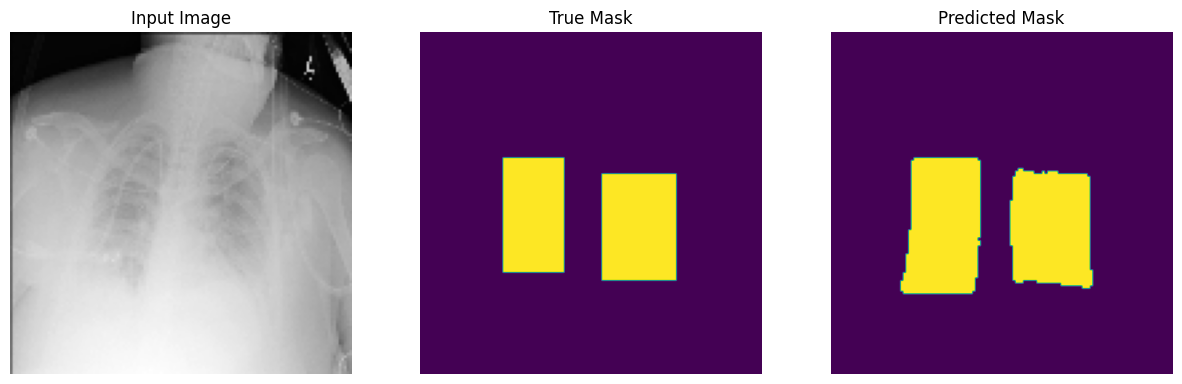

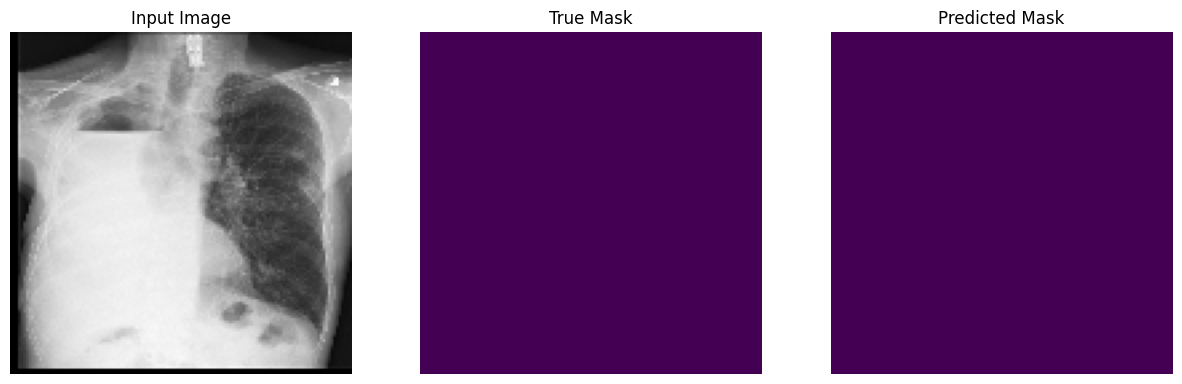

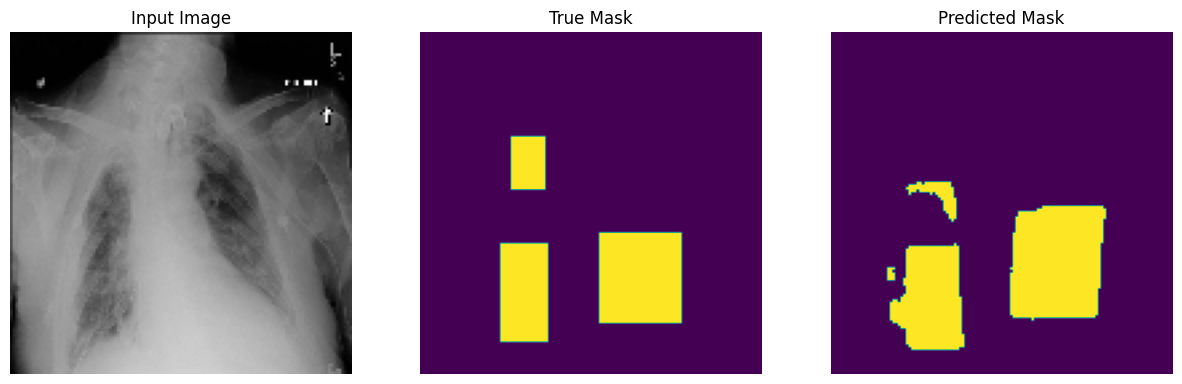

In [ ]:
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model2)

# Visualización de  Mobilenetv2 Encoder

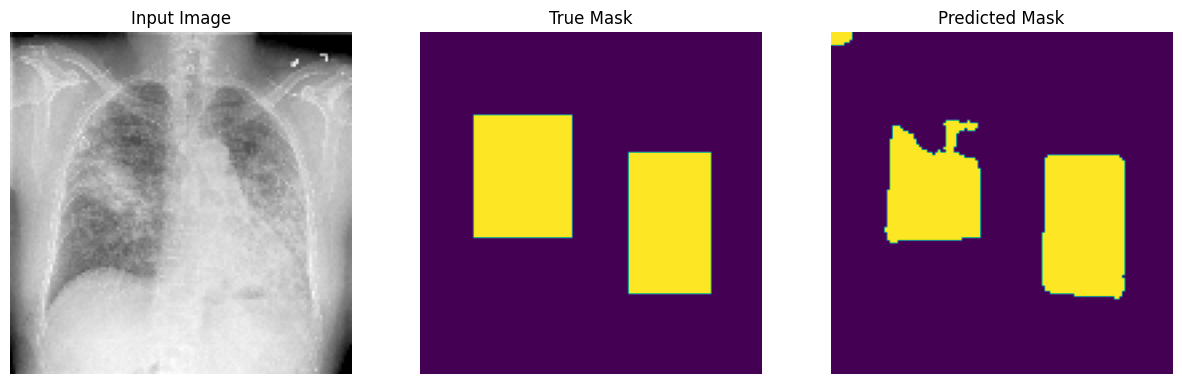

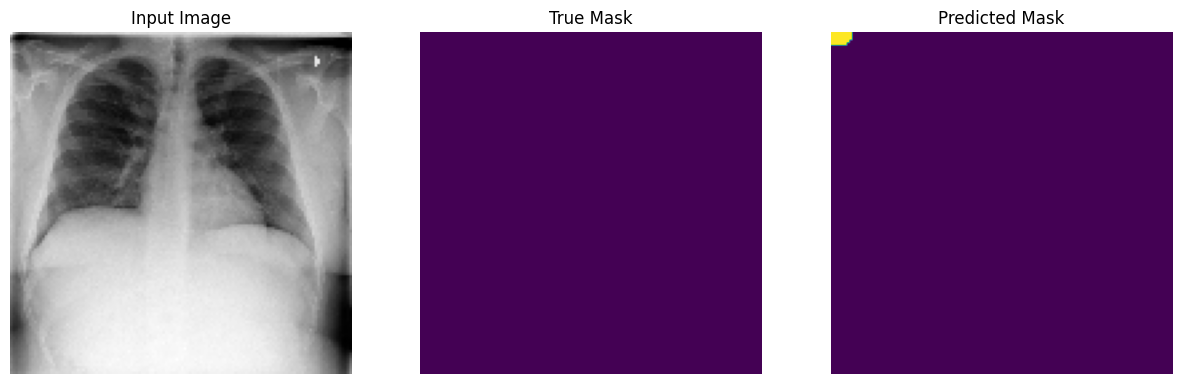

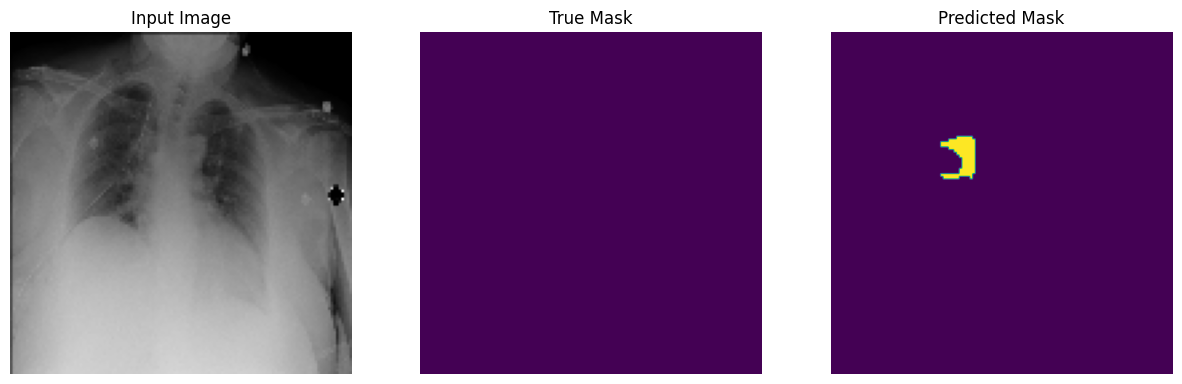

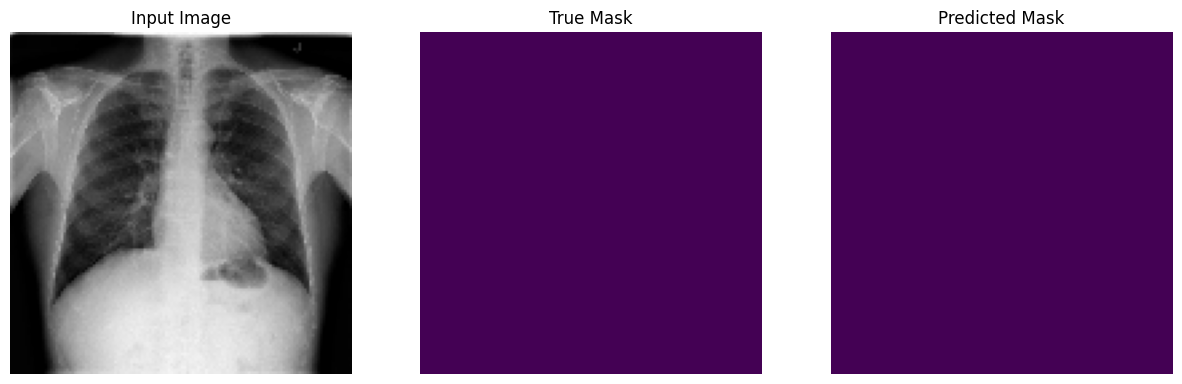

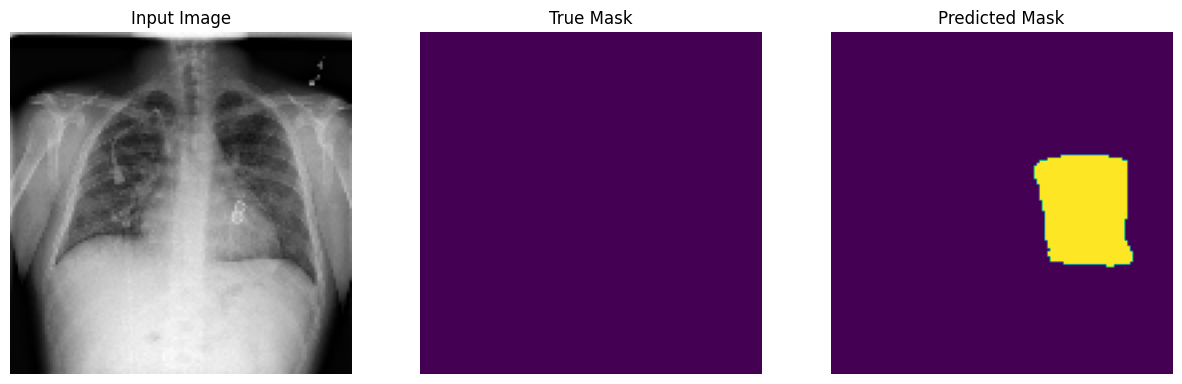

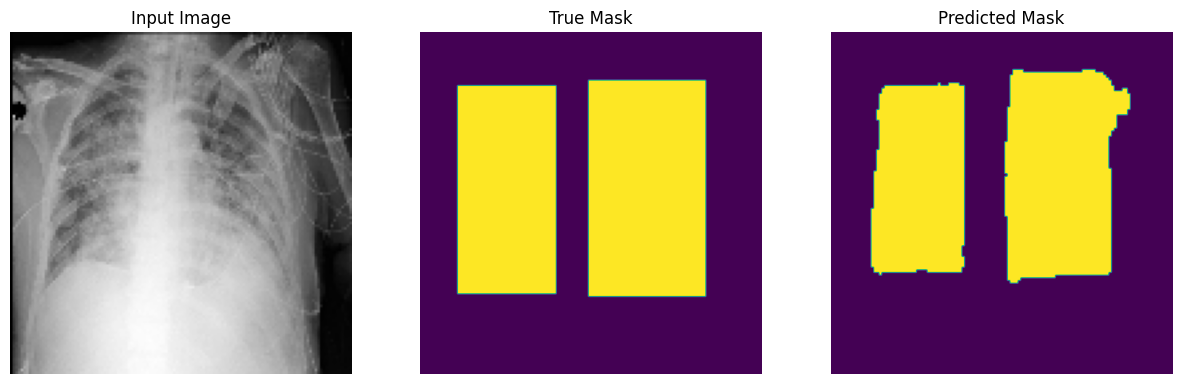

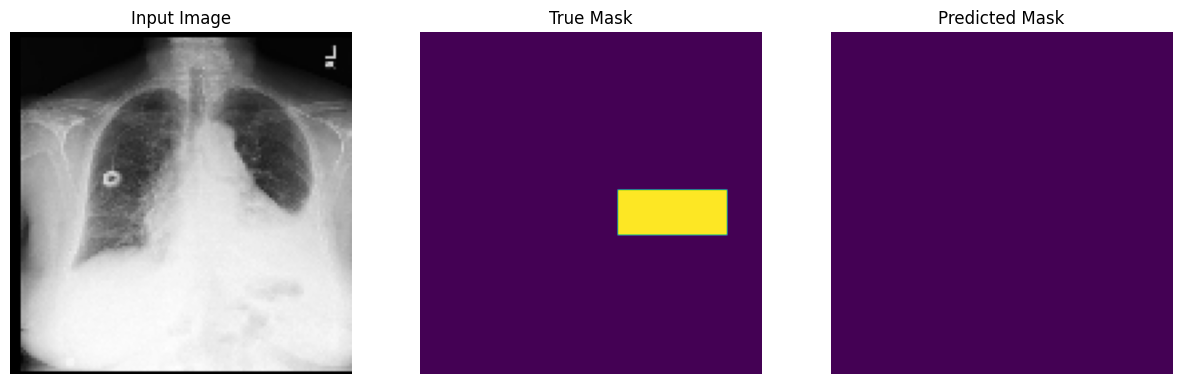

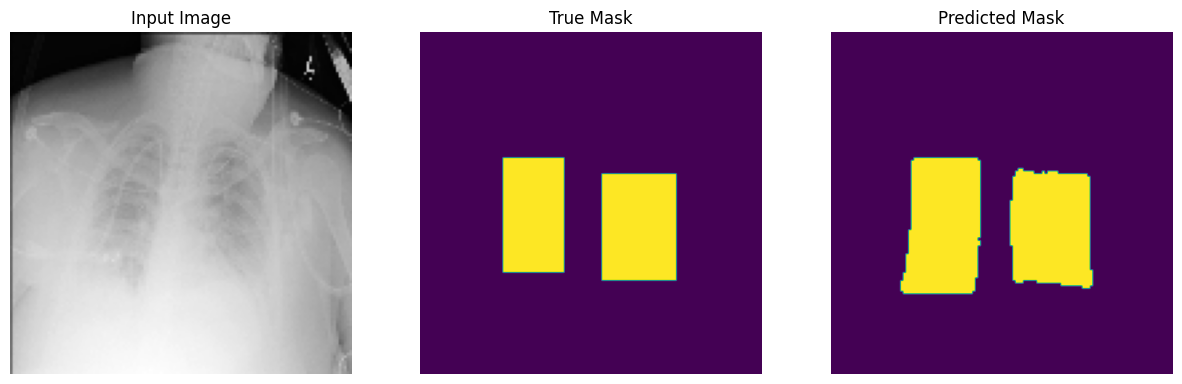

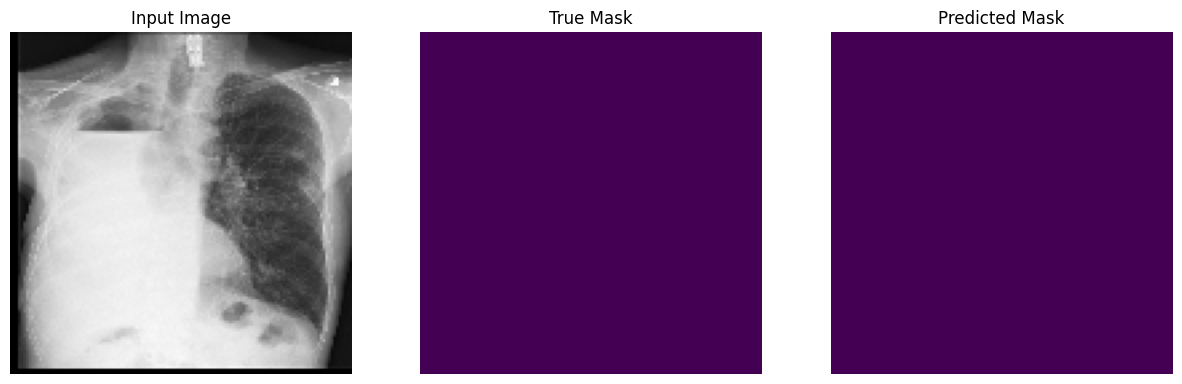

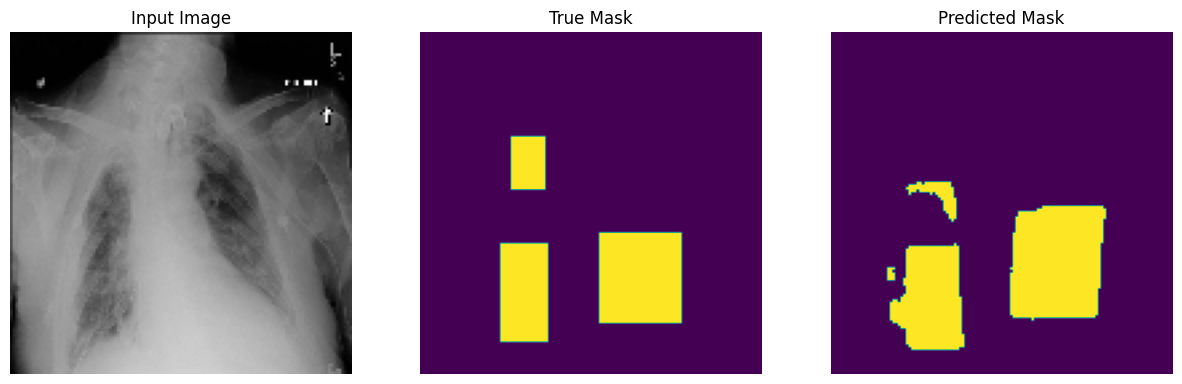

In [ ]:
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model2)

# Puntaje promedio (mean) Iou

In [ ]:

def pred(X,y,model,num):
  #returns the y preds and y accutual

  y_acc = []
  y_pred = []
  for i in range(0,num):
    y_acc.append(y[i].reshape(128,128,1))
    y_pred.append(create_mask1(model.predict(X[i:i+1] , verbose = 0 )) )

  y_acc = np.array(y_acc)
  y_pred = np.array(y_pred)

  return (y_acc,y_pred)


def mean_iou_score(model,X_val,y_val,n_classes = 2 ):
  y_acc , y_pred = pred(X_val,y_val,model , len(y_val))
  IOU_ref = MeanIoU(num_classes=n_classes)
  IOU_ref.update_state(y_acc , y_pred)

  print("Mean iou score ", IOU_ref.result().numpy())

# Mean IOU Score on Resnet50

In [ ]:

mean_iou_score(model1,X_val,mask_val)

Mean iou score  0.83435714


# Mean IOU Score on Densenet121

In [ ]:
mean_iou_score(model2,X_val,mask_val)

Mean iou score  0.8287525


# Mean IOU Score on Mobilenetv2

In [ ]:
mean_iou_score(model3,X_val,mask_val) #Agregar acurracy a los 3 modelos

Mean iou score  0.75355285


# Ensamble

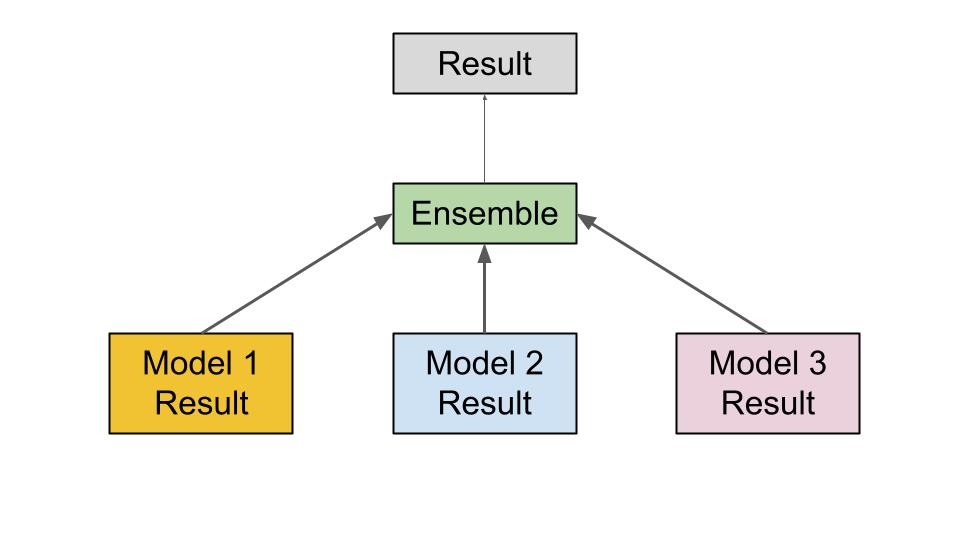

Como muestra la imagen, las salidas de los tres modelos se combinan para aumentar la puntuación media-iou, a medida que la red genera las probabilidades de cada clase de cada píxel, el método sumará esas probabilidades mediante una suma ponderada y luego tomará esa clase. que contiene la mayor probabilidad

In [ ]:
def ensemble(model1,model2,model3,X_test,y_test,n_classes = 2): #Bagging


  pred1 = model1.predict(X_test , verbose = 0 )
  pred2 = model2.predict(X_test , verbose = 0 )
  pred3 = model3.predict(X_test , verbose = 0 )

  preds=np.array([pred1, pred2, pred3])



  weights = [0.4, 0.3, 0.3]

  weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
  weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

  print()
  print("________________________________________________________________")
  print("Ensamble ponderado simple " )
  IOU_weighted = MeanIoU(num_classes=n_classes)
  y_actual = np.expand_dims(mask_val, axis=3)
  IOU_weighted.update_state(y_actual, weighted_ensemble_prediction)
  print('Puntaje IOU de ensamble ponderado simple  = ', IOU_weighted.result().numpy())

  print("________________________________________________________________")
  print()

  for i in range(0,10):
    display([X_test[i:i+1] , mask_val[i].reshape(128,128,1) ,  weighted_ensemble_prediction[i].reshape(128,128,1)])


________________________________________________________________
Ensamble ponderado simple 
Puntaje IOU de ensamble ponderado simple  =  0.84536445
________________________________________________________________



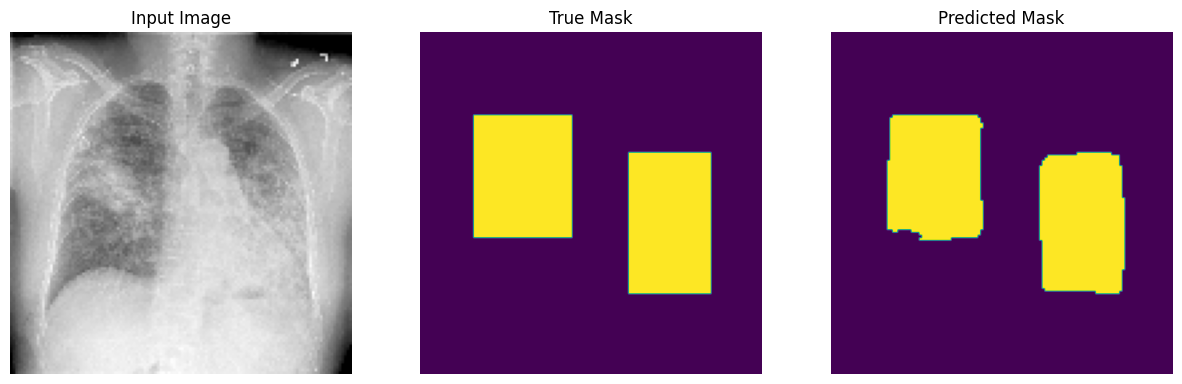

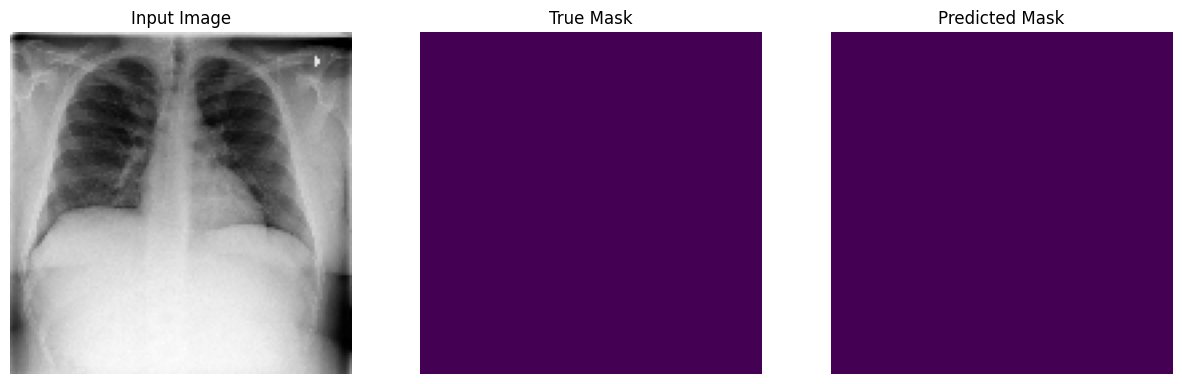

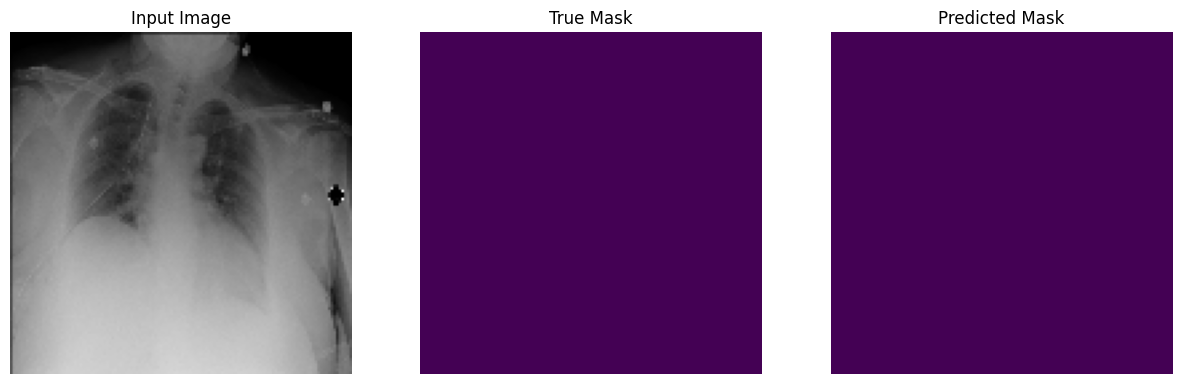

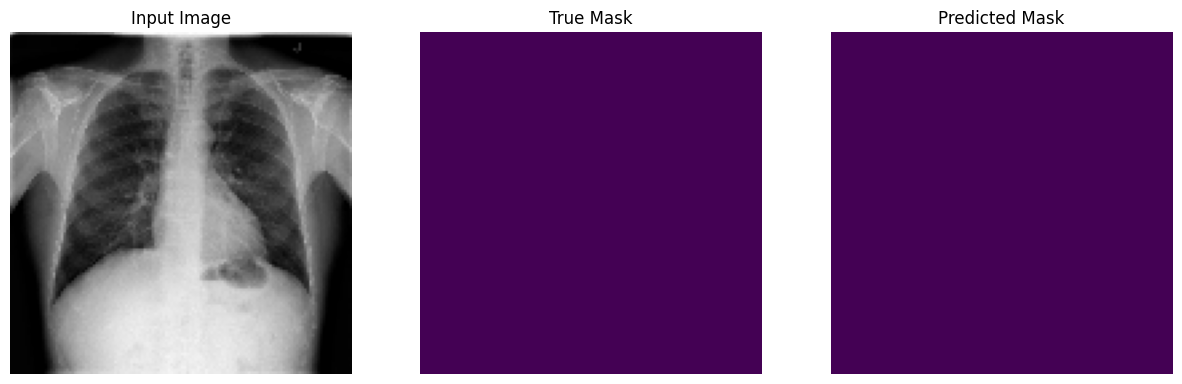

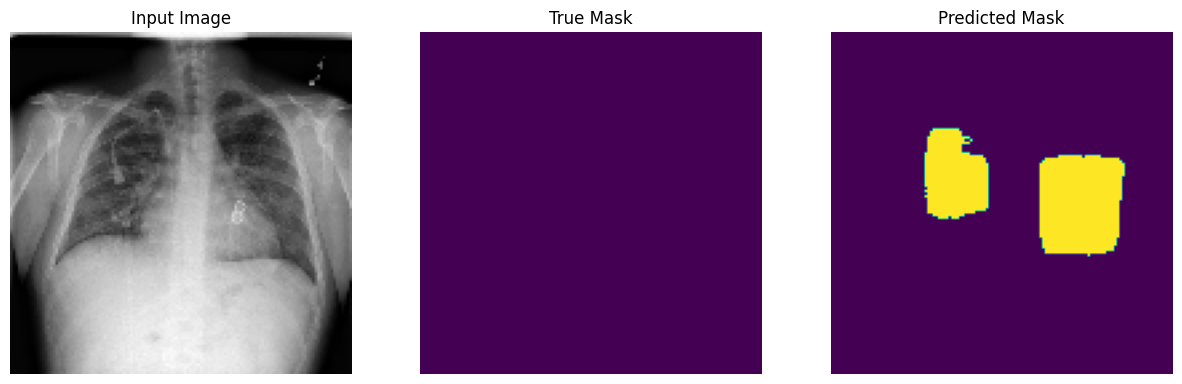

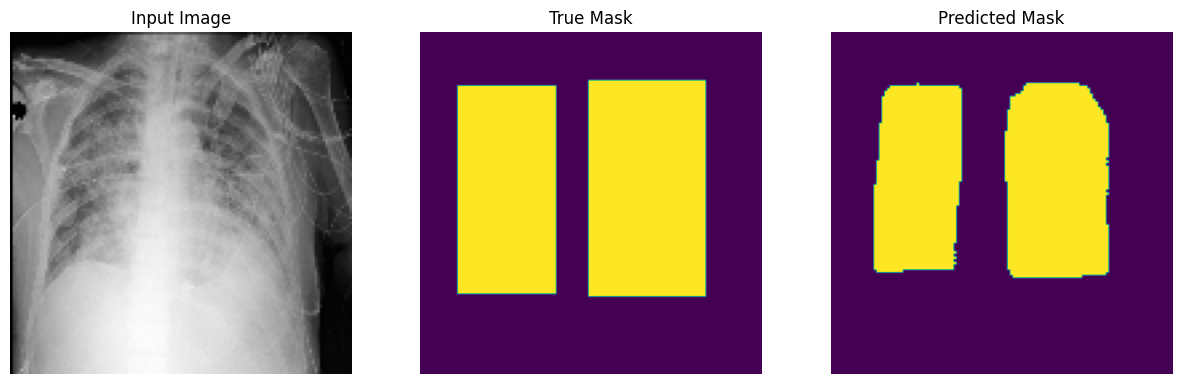

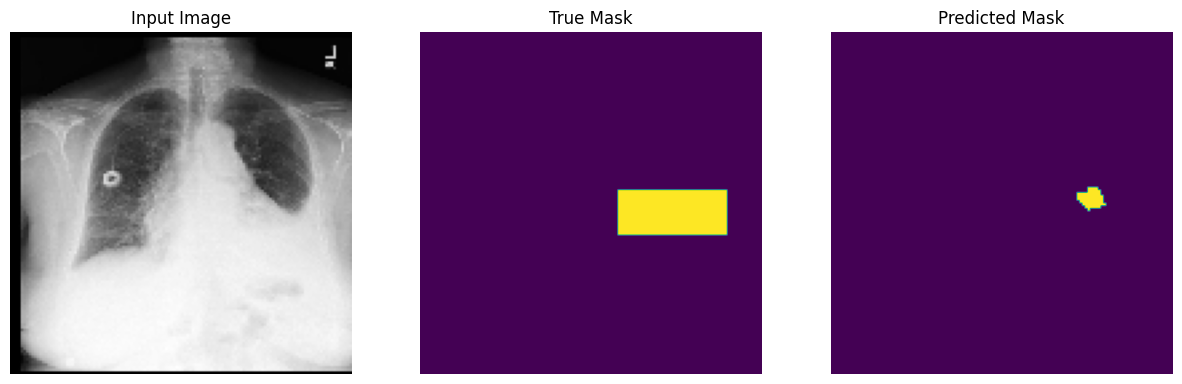

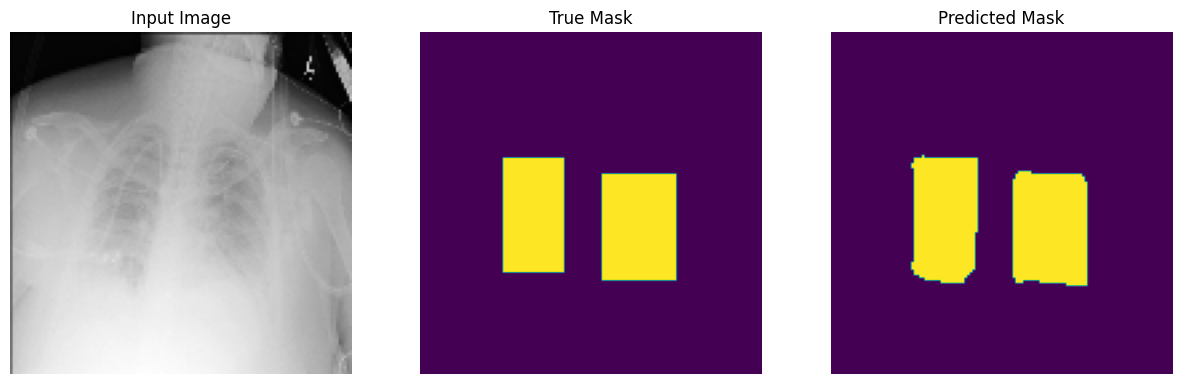

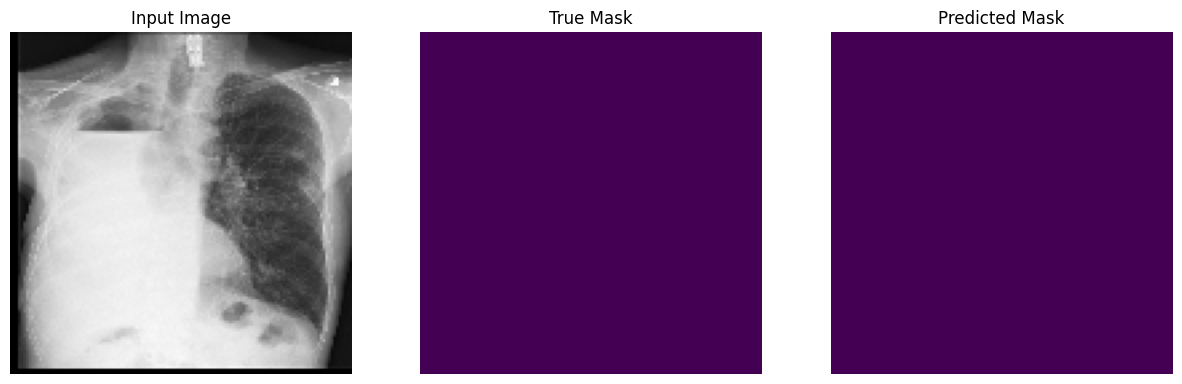

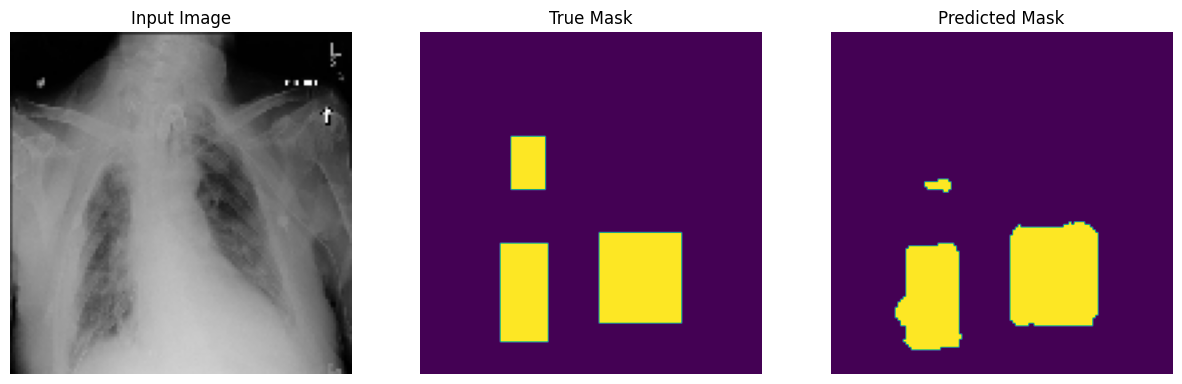

In [ ]:
ensemble(model1,model2,model3,X_val,mask_val) #Revisar y calcular area (IOU) # Agregar el acurracy

# Conclusión

El  Iou score despues de realizar el ensamble aumento, lo mas alto en IoU score era **0.838** ,ahora es **0.850**
